In [ ]:
cd /content/drive/My Drive/Logical-Rhythm-2k20/Sports_Image_Classification

/content/drive/My Drive/Logical-Rhythm-2k20/Sports_Image_Classification


In [ ]:
cd /content/drive/My Drive/Logical-Rhythm-2k20/

/content/drive/My Drive/Logical-Rhythm-2k20


In [ ]:
# ls

### Current directory Structure for Training , Validation and Testing
----
- Sports_Image_Classification

  - Train

    -   Sports_name_1

      - Image_123.jpg
      - Image_127.jpg
      - ...
    -   Sports_name_2

      - Image_256.jpg
      - Image_287.jpg
      - ..

  - Val

    -   Sports_name_1

      - Image_256.jpg
      - Image_287.jpg
      - ..

    -   Sports_name_2

      - Image_256.jpg
      - Image_287.jpg
      - ..

  - test

    -   test

      - Image_1.jpg
      - Image_2.jpg
      - ..







## Importing Libraries

In [ ]:
import fastai
print(fastai.__version__ )

1.0.61


In [ ]:
import numpy as np
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pwd

'/content/drive/My Drive/Logical-Rhythm-2k20/Sports_Image_Classification'

In [ ]:
path = Path('/content/drive/My Drive/Logical-Rhythm-2k20/Sports_Image_Classification')

In [ ]:
path

PosixPath('/content/drive/My Drive/Logical-Rhythm-2k20/Sports_Image_Classification')

In [ ]:
# path.ls()

## Data Augmentation

In [ ]:
# Try and Experiment with values to get better results

# do_flip = True --> a random flip is applied with probability 0.5
# flip_vert = True --> requires do_flip = True, the image will be flipped vertically or rotated by 90 degrees
# max_rotate = 10.0 --> random rotation between -10 to +10 with probability of p_affine
# max_zoom = 1.1 --> random zoom applied between 1 and 1.1 with probability of p_affine
# max_lighting = 0.2 --> lighting and contrast of magnitude between -0.2 and 0.2 applied with probability of p_lighting
# max_wrap = 0.2 --> symmetric warp of magnitude between -0.2 and 0.2 with probability of p_affine
# p_affine = 0.75 --> 0.75 probability used to apply max_rotate, max_zoom, max_wrap
# p_lighting = 0.75 --> 0.75 probability used to apply max_lighting

# trfm = get_transforms(do_flip=True, flip_vert=True, max_rotate=10.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)

trfm = get_transforms()

## Data Loading

In [ ]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train='Train', valid='Val', test = 'test',ds_tfms=trfm, size=224, num_workers=4, bs=32).normalize(imagenet_stats)

In [ ]:
len(data.classes)

22

In [ ]:
# data.show_batch(rows=3, figsize=(9,10))

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds), len(data.test_ds)

(['badminton',
  'baseball',
  'basketball',
  'boxing',
  'chess',
  'cricket',
  'fencing',
  'football',
  'formula1',
  'gymnastics',
  'hockey',
  'ice_hockey',
  'kabaddi',
  'motogp',
  'shooting',
  'swimming',
  'table_tennis',
  'tennis',
  'volleyball',
  'weight_lifting',
  'wrestling',
  'wwe'],
 22,
 9925,
 1115,
 2760)

## Transfer Learning using FastAI
### cnn_learner model making starts using Resnet50 weights as pretrained weights

In [ ]:
learn = cnn_learner(data, models.densenet161, metrics=[error_rate, accuracy])

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


## Best way to Train Model using FastAI modules

1.   First find best learning_rate using lr_find() 

  - Plot the losses against the learning rates (recorder.plot()) and pick a value a bit before the minimum, where the loss still improves.

2.   Train the model using fit_one_cycle(no_of_epochs, range_of_learning_rate)

  - for training freezed model (i.e. transfer learning) use a fixed learning_rate found using Step 1.

3.   Now comes Fine-Tuning part 

  - Load the model trained above 
  - Unfreeze its layers 
  - find range of learning_rate 
  
    - - The maximum should be the value picked with the Learning Rate Finder
    - - The lower one can be ten/five times lower.
  - The idea for using above ranged learning rate is :-
    - - using a lower value to warm-up the training 
    - - during the middle of the cycle, the high learning rates will act as regularization method, and keep the network from overfitting.

4.   #### For more details see [Sylvain Gugger Blog](https://sgugger.github.io/the-1cycle-policy.html)

### Finding Learning_rate using lr_find()

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


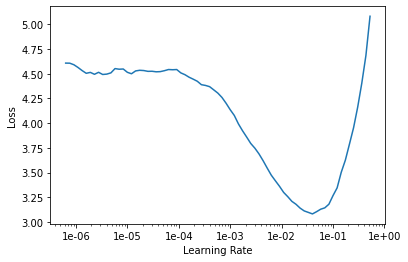

In [ ]:
learn.recorder.plot()

In [ ]:
# lr = 3e-02 or lr = 1e-01 gives worst result accuracy does not increase after 1st epoch and valid_loss never decreases
# trying lr = 1e-02
lr = 1e-02

In [ ]:
lr

0.01

### Training Model 
- here the training is done when all the layers of model is freezed

In [ ]:
learn.callback_fns.append(partial(SaveModelCallback, name='res50-stage-1'))

In [ ]:
learn.callback_fns.append(partial(SaveModelCallback, name='densenet-stage-1'))

In [ ]:
learn.fit_one_cycle(15, slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.744865,0.418013,0.116592,0.883408,03:07
1,0.665688,0.470025,0.123767,0.876233,03:04
2,0.742895,0.502627,0.118386,0.881614,03:03
3,0.620437,0.416624,0.109417,0.890583,03:04
4,0.508562,0.374658,0.091480,0.908520,03:04
5,0.437459,0.398827,0.104036,0.895964,03:04
6,0.394163,0.369523,0.100448,0.899552,03:03
7,0.310313,0.313079,0.077130,0.922870,03:03
8,0.305755,0.320036,0.081614,0.918386,03:03
9,0.233270,0.292636,0.069058,0.930942,03:03


Better model found at epoch 0 with valid_loss value: 0.41801294684410095.
Better model found at epoch 3 with valid_loss value: 0.4166238009929657.
Better model found at epoch 4 with valid_loss value: 0.37465807795524597.
Better model found at epoch 6 with valid_loss value: 0.3695228397846222.
Better model found at epoch 7 with valid_loss value: 0.31307947635650635.
Better model found at epoch 9 with valid_loss value: 0.29263588786125183.
Better model found at epoch 11 with valid_loss value: 0.29141607880592346.
Better model found at epoch 12 with valid_loss value: 0.2790788412094116.


In [ ]:
learn.load('densenet-stage-1'); # remove ';' to see model

# Creating Output Submission CSV file

In [ ]:
from pathlib import Path
p = Path("/content/drive/My Drive/Logical-Rhythm-2k20/Sports_Image_Classification/test/test")

In [ ]:
dire = p.glob("*.jpg")
img_pred = {}
for img_path in dire:
  img = open_image(img_path)
  pred_class,pred_idx,outputs = learn.predict(img)
  img_label = str(img_path).split('/')[-1]
  img_pred[img_label] = pred_class
print(len(img_pred))

2760


In [ ]:
imggg = open_image('/content/drive/My Drive/Logical-Rhythm-2k20/Sports_Image_Classification/test/test/0.jpg')

In [ ]:
pred_class,pred_idx,outputs = learn.predict(imggg)
print(pred_class, pred_idx, outputs, img_path)

football tensor(7) tensor([2.7266e-08, 6.3503e-10, 1.1469e-10, 5.0988e-12, 1.7066e-10, 1.6488e-09,
        1.8798e-11, 1.0000e+00, 1.4012e-10, 1.1222e-10, 1.0662e-07, 5.2750e-12,
        7.5000e-11, 1.2587e-10, 1.1142e-10, 2.0793e-12, 1.4296e-09, 9.5520e-10,
        5.0928e-11, 8.7374e-11, 3.4992e-11, 4.1562e-11]) /content/drive/My Drive/Logical-Rhythm-2k20/Sports_Image_Classification/test/test/1305.jpg


In [ ]:
test_images_list = pd.read_csv('/content/drive/My Drive/Logical-Rhythm-2k20/Sports_Image_Classification/test_images_list.csv')

In [ ]:
test_images_list.head()

,image
0,./test/0.jpg
1,./test/1.jpg
2,./test/2.jpg
3,./test/3.jpg
4,./test/4.jpg


In [ ]:
df_pred = pd.DataFrame(columns=['image', 'sports'])

In [ ]:
for idx in test_images_list.index:
  img_name = test_images_list['image'][idx]
  img_no = test_images_list['image'][idx].split('/')[-1]
  label = img_pred[img_no]
  df_pred = df_pred.append({'image' : img_name, 'sports' : label}, ignore_index=True)

In [ ]:
print(df_pred.shape)
print(df_pred.head())

(2760, 2)
          image      sports
0  ./test/0.jpg    football
1  ./test/1.jpg      motogp
2  ./test/2.jpg  ice_hockey
3  ./test/3.jpg   badminton
4  ./test/4.jpg     fencing


In [ ]:
df_pred.to_csv('my_sub_fastai_dense_1.csv', index = False)